This document wants to train a neural network, to predict the baseline power output for a simple farm, with given wind directions.

https://github.com/stared/thinking-in-tensors-writing-in-pytorch/blob/master/5%20Nonlinear%20regression.ipynb

In [1]:
# Importing stuff
import numpy as np
from floris.tools import FlorisInterface
import matplotlib.pyplot as plt
import os
import time

In [2]:
# Creating the farm:
dist = 5
nx = 3
ny = 3
turb_type = 'nrel_5MW'
combination = 'sosfs'
deflection = 'gauss'
turbulence = 'crespo_hernandez'
velocity = 'gauss'
WS_min = 4
WS_max = 20
TI_min = 0.01
TI_max = 0.15
wd_min = 270
wd_max = 360
yaw_max = 25
rho = 1.225
seed = 0

In [3]:
fi = FlorisInterface("gch.yaml")   
        
#Turns it into a dictionary and then does the changes to the model
fi_dict = fi.floris.as_dict()

fi_dict["farm"]["turbine_type"] = [turb_type]
fi_dict["wake"]["model_strings"]["combination_model"] = combination
fi_dict["wake"]["model_strings"]["deflection_model"]  = deflection
fi_dict["wake"]["model_strings"]["turbulence_model"]  = turbulence
fi_dict["wake"]["model_strings"]["velocity_model"]    = velocity
fi_dict["flow_field"]["air_density"]                  = rho

# Turns it back into a floris object:
fi = FlorisInterface(fi_dict)

D = fi.floris.farm.rotor_diameters[0]

x = np.linspace(0, D*dist*nx, nx)
y = np.linspace(0, D*dist*ny, ny)

xv, yv = np.meshgrid(x, y, indexing='xy')

layout_x =  xv.flatten()
layout_y = yv.flatten()

In [4]:
n_wind_dir = 100

In [5]:
wd = np.linspace(270, 315, num = n_wind_dir)

In [6]:
TI = 0.07
ws = 7
fi.reinitialize(
    layout=(layout_x, layout_y),
    wind_directions=wd,
    turbulence_intensity= TI,
    wind_speeds=[ws]
    )

In [7]:
fi.calculate_wake()

In [8]:
farm_power = fi.get_farm_power()

In [13]:
farm_power.shape

(100, 1)

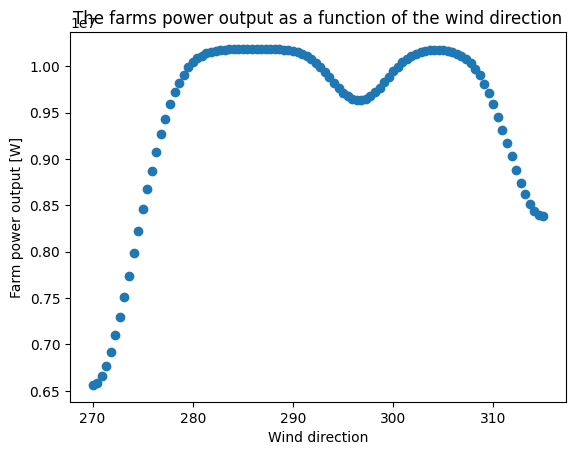

In [14]:
plt.scatter(wd, farm_power)
plt.xlabel("Wind direction")
plt.ylabel("Farm power output [W]")
plt.title("The farms power output as a function of the wind direction")
plt.show()

In [35]:
# Importing machine larning stuff
from sklearn.model_selection import train_test_split
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [37]:
X_data = wd
y_data = farm_power
len(X_data), len(y_data)

(100, 100)

In [38]:
seed = 1

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=seed, shuffle=True)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=seed) # 0.25 x 0.8 = 0.2

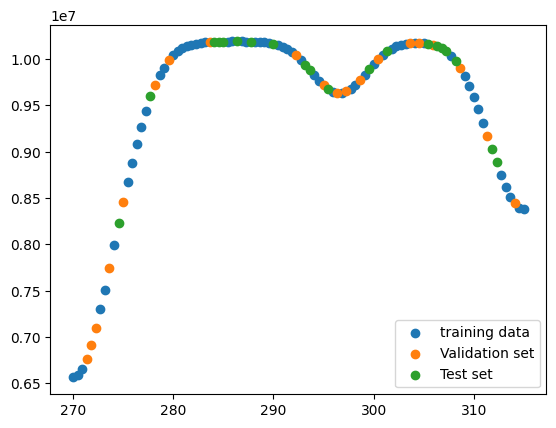

In [40]:
plt.scatter(X_train,y_train, label="training data")
plt.scatter(X_val, y_val, label="Validation set")
plt.scatter(X_test, y_test, label ="Test set")

plt.legend()
plt.show()


In [48]:
class Baseline_Power(nn.Module):
  def __init__(self):
    """Initializes multi-class classification model.
    
    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super(Baseline_Power, self).__init__()
    self.linear_layer_stack = nn.Sequential(nn.Linear(1, 1024),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(1024, 1024),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(1024, 1))

    n1 = 8 # no. nodes in layer 1
    n2 = 5 # no. nodes in layer 2
    n3 = 4 # no. nodes in layer 3
    n4 = 5 # no. nodes in layer 4
    n5 = 2 # no. nodes in layer 5
    self.fc1 = nn.Linear(1,n1)
    self.fc2 = nn.Linear(n1,n2)
    self.fc3 = nn.Linear(n2,n3)
    self.fc4 = nn.Linear(n3,n4)
    self.fc5 = nn.Linear(n4,n5)
    self.fc6 = nn.Linear(n5,1)



  def forward(self, x):
    
    x = torch.tanh(self.fc1(x))
    x = torch.sigmoid(self.fc2(x)) 
    x = torch.sigmoid(self.fc3(x)) 
    x = torch.tanh(self.fc4(x)) 
    x = torch.tanh(self.fc5(x))
    return self.fc6(x)
    #return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_1 = Baseline_Power().to(device)

model_1

Baseline_Power(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=1, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=5, bias=True)
  (fc5): Linear(in_features=5, out_features=2, bias=True)
  (fc6): Linear(in_features=2, out_features=1, bias=True)
)

In [49]:
LR = 1e-6
MAX_EPOCH = 100
BATCH_SIZE = 512

In [50]:
optimizer = optim.Adam(model_1.parameters(), lr=LR)
loss_fn = nn.MSELoss(reduction="mean")

In [51]:
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)/10000000
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)/10000000

X_train = torch.unsqueeze(X_train, dim=1)
X_test = torch.unsqueeze(X_test, dim=1)
X_train.size()

TypeError: expected np.ndarray (got Tensor)

In [62]:
torch.manual_seed(seed)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 150_000

# Track different values
epoch_count = [] 
loss_values = []
test_loss_values = [] 

### Training
# 0. Loop through the data
for epoch in range(epochs): 
  # Set the model to training mode
  model_1.train() # train mode in PyTorch sets all parameters that require gradients to require gradients 

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad() 

  # 4. Perform backpropagation on the loss with respect to the parameters of the model (calculate gradients of each parameter)
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_1.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A
  # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass 
    test_pred = model_1(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin'
  if epoch % 10000 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    # print(model_1.state_dict())

Epoch: 0 | Loss: 1.3128520250320435 | Test loss: 1.3838950395584106
Epoch: 10000 | Loss: 1.1934813261032104 | Test loss: 1.2609399557113647
Epoch: 20000 | Loss: 1.0772181749343872 | Test loss: 1.141007661819458
Epoch: 30000 | Loss: 0.964645504951477 | Test loss: 1.0246866941452026
Epoch: 40000 | Loss: 0.8568539023399353 | Test loss: 0.9130927920341492
Epoch: 50000 | Loss: 0.7525120973587036 | Test loss: 0.8048319220542908
Epoch: 60000 | Loss: 0.6518233418464661 | Test loss: 0.7000910639762878
Epoch: 70000 | Loss: 0.5558637976646423 | Test loss: 0.5999619960784912
Epoch: 80000 | Loss: 0.4655730724334717 | Test loss: 0.5053985714912415
Epoch: 90000 | Loss: 0.3821237087249756 | Test loss: 0.41760531067848206
Epoch: 100000 | Loss: 0.3060610890388489 | Test loss: 0.337135374546051
Epoch: 110000 | Loss: 0.23727965354919434 | Test loss: 0.2638495862483978
Epoch: 120000 | Loss: 0.17562492191791534 | Test loss: 0.19753305613994598
Epoch: 130000 | Loss: 0.12239720672369003 | Test loss: 0.1395178

In [63]:
model_1.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A

    y_pred = model_1(X_train)

In [67]:
y_pred

tensor([[0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0.7591],
        [0

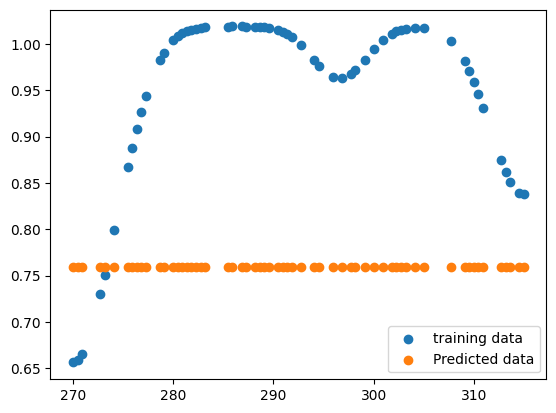

In [64]:
plt.scatter(X_train.cpu(), y_train.cpu(), label="training data")
plt.scatter(X_train.cpu(), y_pred.cpu(), label="Predicted data")

plt.legend()
plt.show()

In [24]:
class SineApproximator(nn.Module):
    def __init__(self):
        super(SineApproximator, self).__init__()
        n1 = 8 # no. nodes in layer 1
        n2 = 5 # no. nodes in layer 2
        n3 = 4 # no. nodes in layer 3
        n4 = 5 # no. nodes in layer 4
        n5 = 2 # no. nodes in layer 5
        self.fc1 = nn.Linear(1,n1)
        self.fc2 = nn.Linear(n1,n2)
        self.fc3 = nn.Linear(n2,n3)
        self.fc4 = nn.Linear(n3,n4)
        self.fc5 = nn.Linear(n4,n5)
        self.fc6 = nn.Linear(n5,1)


    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) 
        x = torch.sigmoid(self.fc3(x)) 
        x = torch.tanh(self.fc4(x)) 
        x = torch.tanh(self.fc5(x))
        return self.fc6(x)


In [18]:
X = wd #np.random.rand(10**5) * 2 * np.pi
y = farm_power/10000000 #np.sin(X)

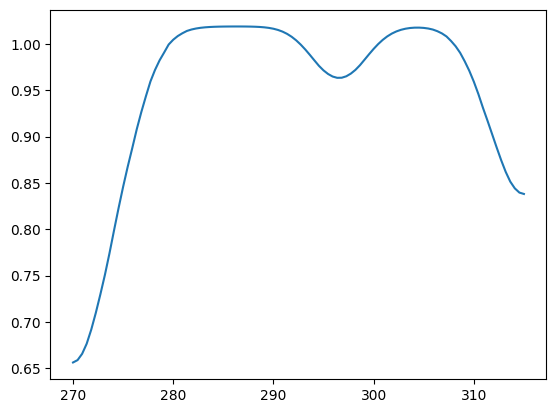

In [20]:
plt.plot(X,y)
plt.show()

In [21]:
X_train, X_val, y_train, y_val = map(torch.tensor, train_test_split(X, y, test_size=0.2))
train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=True)


In [25]:
model = SineApproximator().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss(reduction="mean")

In [27]:
# training loop
train_loss_list = list()
val_loss_list = list()
for epoch in range(MAX_EPOCH):
    print("epoch %d / %d" % (epoch+1, MAX_EPOCH))
    model.train()
    # training loop
    temp_loss_list = list()
    for X_train, y_train in train_dataloader:
        X_train = X_train.type(torch.float32).to(device)
        y_train = y_train.type(torch.float32).to(device)

        optimizer.zero_grad()

        score = model(X_train)
        loss = criterion(input=score, target=y_train)
        #loss.requires_grad = True
        loss.backward()

        optimizer.step()

        temp_loss_list.append(loss.detach().cpu().numpy())
    
    temp_loss_list = list()
    for X_train, y_train in train_dataloader:
        X_train = X_train.type(torch.float32).to(device)
        y_train = y_train.type(torch.float32).to(device)

        score = model(X_train)
        loss = criterion(input=score, target=y_train)

        temp_loss_list.append(loss.detach().cpu().numpy())
    
    train_loss_list.append(np.average(temp_loss_list))

    # validation
    model.eval()
    
    temp_loss_list = list()
    for X_val, y_val in val_dataloader:
        X_val = X_val.type(torch.float32).to(device)
        y_val = y_val.type(torch.float32).to(device)

        score = model(X_val)
        loss = criterion(input=score, target=y_val)

        temp_loss_list.append(loss.detach().cpu().numpy())
    
    val_loss_list.append(np.average(temp_loss_list))

    print("\ttrain loss: %.5f" % train_loss_list[-1])
    print("\tval loss: %.5f" % val_loss_list[-1])

epoch 1 / 100


C:\Users\Marcus\anaconda3\envs\thesis\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([80, 1, 1])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Marcus\anaconda3\envs\thesis\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([20, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


	train loss: 0.76915
	val loss: 0.78896
epoch 2 / 100
	train loss: 0.76914
	val loss: 0.78895
epoch 3 / 100
	train loss: 0.76914
	val loss: 0.78894
epoch 4 / 100
	train loss: 0.76913
	val loss: 0.78894
epoch 5 / 100
	train loss: 0.76913
	val loss: 0.78893
epoch 6 / 100
	train loss: 0.76912
	val loss: 0.78893
epoch 7 / 100
	train loss: 0.76911
	val loss: 0.78892
epoch 8 / 100
	train loss: 0.76911
	val loss: 0.78891
epoch 9 / 100
	train loss: 0.76910
	val loss: 0.78891
epoch 10 / 100
	train loss: 0.76910
	val loss: 0.78890
epoch 11 / 100
	train loss: 0.76909
	val loss: 0.78890
epoch 12 / 100
	train loss: 0.76909
	val loss: 0.78889
epoch 13 / 100
	train loss: 0.76908
	val loss: 0.78888
epoch 14 / 100
	train loss: 0.76907
	val loss: 0.78888
epoch 15 / 100
	train loss: 0.76907
	val loss: 0.78887
epoch 16 / 100
	train loss: 0.76906
	val loss: 0.78887
epoch 17 / 100
	train loss: 0.76906
	val loss: 0.78886
epoch 18 / 100
	train loss: 0.76905
	val loss: 0.78885
epoch 19 / 100
	train loss: 0.769

In [28]:
model.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A

    y_pred = model(X_train)

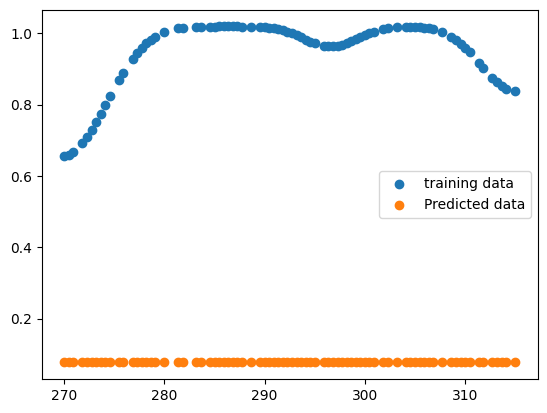

In [29]:
plt.scatter(X_train.cpu(), y_train.cpu(), label="training data")
plt.scatter(X_train.cpu(), y_pred.cpu(), label="Predicted data")

plt.legend()
plt.show()

In [141]:
X_train.shape

torch.Size([100])

In [151]:
class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        # n_features = no. inputs
        n1 = 8 # no. nodes in layer 1
        n2 = 5 # no. nodes in layer 2
        n3 = 4 # no. nodes in layer 3
        n4 = 5 # no. nodes in layer 4
        n5 = 2 # no. nodes in layer 5
        self.fc1 = nn.Linear(n_features,n1)
        self.fc2 = nn.Linear(n1,n2)
        self.fc3 = nn.Linear(n2,n3)
        self.fc4 = nn.Linear(n3,n4)
        self.fc5 = nn.Linear(n4,n5)
        self.fc6 = nn.Linear(n5,1)
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) 
        x = torch.sigmoid(self.fc3(x)) 
        x = torch.tanh(self.fc4(x)) 
        x = torch.tanh(self.fc5(x))
        return self.fc6(x)

torch.manual_seed(2809)
X_train = torch.randn(64, 10)
y_train = torch.randn(64, 1)

# X_train = wd
# y_train = farm_power/10000000

# X_train = torch.from_numpy(X_train).float().to(device)
# y_train = torch.from_numpy(y_train).float().to(device)

# X_train = torch.unsqueeze(X_train, dim=1)


#net = Net(1).to(device)
net = Net(1).to(X_train.shape[1])

criterion = nn.MSELoss() # loss function
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

## training 
for epoch in range(1000):
    y_pred = net(X_train)
    train_loss = criterion(y_pred, y_train)
    optimizer.zero_grad()        
    train_loss.backward()
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, train_loss.item()))

plt.figure()
plt.plot(y_pred.detach().numpy(), label='predicted')
plt.plot(y_train.numpy(), label='actual')
plt.ylabel('output y')
plt.legend()
plt.show()

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

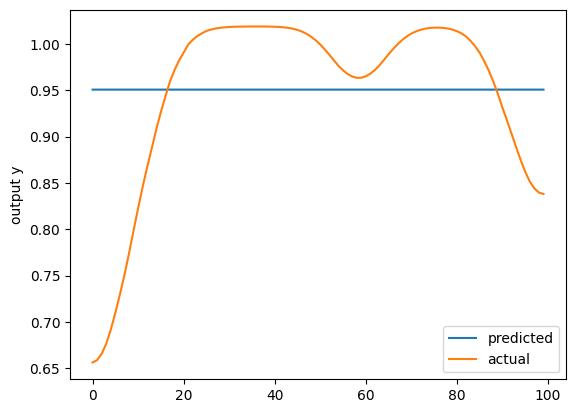

In [148]:
plt.figure()
plt.plot(y_pred.cpu().detach().numpy(), label='predicted')
plt.plot(y_train.cpu().detach().numpy(), label='actual')
plt.ylabel('output y')
plt.legend()
plt.show()


#plt.scatter(X_train.cpu(), y_train.cpu(), label="training data")
#plt.scatter(X_train.cpu(), y_pred.cpu(), label="Predicted data")

In [82]:
wd

array([270.        , 270.45454545, 270.90909091, 271.36363636,
       271.81818182, 272.27272727, 272.72727273, 273.18181818,
       273.63636364, 274.09090909, 274.54545455, 275.        ,
       275.45454545, 275.90909091, 276.36363636, 276.81818182,
       277.27272727, 277.72727273, 278.18181818, 278.63636364,
       279.09090909, 279.54545455, 280.        , 280.45454545,
       280.90909091, 281.36363636, 281.81818182, 282.27272727,
       282.72727273, 283.18181818, 283.63636364, 284.09090909,
       284.54545455, 285.        , 285.45454545, 285.90909091,
       286.36363636, 286.81818182, 287.27272727, 287.72727273,
       288.18181818, 288.63636364, 289.09090909, 289.54545455,
       290.        , 290.45454545, 290.90909091, 291.36363636,
       291.81818182, 292.27272727, 292.72727273, 293.18181818,
       293.63636364, 294.09090909, 294.54545455, 295.        ,
       295.45454545, 295.90909091, 296.36363636, 296.81818182,
       297.27272727, 297.72727273, 298.18181818, 298.63

In [78]:
torch.arange(0,10,0.1)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000, 5.0000, 5.1000, 5.2000, 5.3000,
        5.4000, 5.5000, 5.6000, 5.7000, 5.8000, 5.9000, 6.0000, 6.1000, 6.2000,
        6.3000, 6.4000, 6.5000, 6.6000, 6.7000, 6.8000, 6.9000, 7.0000, 7.1000,
        7.2000, 7.3000, 7.4000, 7.5000, 7.6000, 7.7000, 7.8000, 7.9000, 8.0000,
        8.1000, 8.2000, 8.3000, 8.4000, 8.5000, 8.6000, 8.7000, 8.8000, 8.9000,
        9.0000, 9.1000, 9.2000, 9.3000, 9.4000, 9.5000, 9.6000, 9.7000, 9.8000,
        9.9000])

In [92]:
class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        # n_features = no. inputs
        n1 = 8 # no. nodes in layer 1
        n2 = 5 # no. nodes in layer 2
        n3 = 4 # no. nodes in layer 3
        n4 = 5 # no. nodes in layer 4
        n5 = 2 # no. nodes in layer 5
        self.fc1 = nn.Linear(n_features,n1)
        self.fc2 = nn.Linear(n1,n2)
        self.fc3 = nn.Linear(n2,n3)
        self.fc4 = nn.Linear(n3,n4)
        self.fc5 = nn.Linear(n4,n5)
        self.fc6 = nn.Linear(n5,1)
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) 
        x = torch.sigmoid(self.fc3(x)) 
        x = torch.tanh(self.fc4(x)) 
        x = torch.tanh(self.fc5(x))
        return self.fc6(x)

torch.manual_seed(2809)

#X_train = torch.randn(64, 1)
X_train = torch.from_numpy(wd).float()/360
X_train = torch.unsqueeze(X_train, 1)
y_train = torch.randn(len(X_train), 1)
y_train = torch.from_numpy(farm_power).float()/1000000
print("x shape:", X_train.shape)
print("y shape", y_train.shape)
net = Net(X_train.shape[1])
criterion = nn.MSELoss() # loss function
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

## training 
for epoch in range(15000):
    y_pred = net(X_train)
    train_loss = criterion(y_pred, y_train)
    optimizer.zero_grad()        
    train_loss.backward()
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, train_loss.item()))


x shape: torch.Size([100, 1])
y shape torch.Size([100, 1])
epoch 0, loss 92.26953125
epoch 1, loss 92.18547058105469
epoch 2, loss 92.10131072998047
epoch 3, loss 92.01702117919922
epoch 4, loss 91.93265533447266
epoch 5, loss 91.8481674194336
epoch 6, loss 91.7635726928711
epoch 7, loss 91.67886352539062
epoch 8, loss 91.59407043457031
epoch 9, loss 91.5091781616211
epoch 10, loss 91.42418670654297
epoch 11, loss 91.33908081054688
epoch 12, loss 91.2538833618164
epoch 13, loss 91.16859436035156
epoch 14, loss 91.08319091796875
epoch 15, loss 90.9977035522461
epoch 16, loss 90.912109375
epoch 17, loss 90.82642364501953
epoch 18, loss 90.74065399169922
epoch 19, loss 90.6547622680664
epoch 20, loss 90.56878662109375
epoch 21, loss 90.48272705078125
epoch 22, loss 90.39655303955078
epoch 23, loss 90.310302734375
epoch 24, loss 90.22393798828125
epoch 25, loss 90.13748168945312
epoch 26, loss 90.05093383789062
epoch 27, loss 89.96428680419922
epoch 28, loss 89.8775405883789
epoch 29, loss

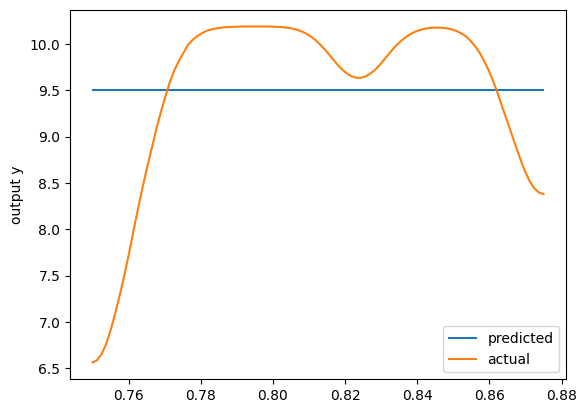

In [93]:
plt.figure()
plt.plot(X_train.detach().numpy(), y_pred.detach().numpy(), label='predicted')
plt.plot(X_train.detach().numpy(), y_train.numpy(), label='actual')
plt.ylabel('output y')
plt.legend()
plt.show()

In [87]:
test = torch.from_numpy(farm_power).float().to(device)

In [88]:
test.shape

torch.Size([100, 1])